# Song Recommender

### Objective 


In this exercise we are given song data from a streaming music startup.  The site allows people to stream music from their phone for free.  They currently only have beatles songs but they want to expand soon.

They still have all their data in json files and they are interested in getting some basic info about their users as well as building a very preliminary song recommendation model in order to increase user engagement.


Working with json files is important if you join a very early stage start-up, they might not have a
nice database and all data will be in jsons. Third party data are often stored in json files as well.  So it's just good to get familiar with using json.

But to warn you, it's gonna be messy most of the time.

The CEO hypothetically asked me very specific questions:
* What are the top 3 and the bottom 3 states in terms of number of users?
* What are the top 3 and the bottom 3 states in terms of user engagement? 
    * You can choose how to mathematically define user engagement. 
    * What the CEO cares about here is in which states users are using the product a lot/very little.
* The CEO wants to send a gift to the first user who signed-up for each state. 
    * That is, the first user who signed-up from California, from Oregon, etc. 
        * Can you give him a list of those users?
* Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. 
    * That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? 
    * This is going to be v1 of a song recommendation model.
* How would you set up a test to check whether your model works well and is improving engagement?


<u>Data on our fields in the json file includes:</u>
* id : unique identifier oM the row
* user_id : user id who listened to a given song
* user_state : where the user is based
* user_sign_up_date : when the user signed-up
* song_played : the song that was listened
* time_played : at which time the user started listening to the song (local time)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.pipeline import Pipeline
from numpy.random import beta as beta_dist

# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

from scipy.stats import skew, skewtest
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, Perceptron
import datetime
# Importing Machine learning models library used for classification
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, BaggingClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,roc_curve, auc
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split
# import the class
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import f_regression,f_classif
from sklearn import metrics

import matplotlib.patheffects as path_effects
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
import xgboost as xgb

# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 10)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. T

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Left', 'Stayed']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return

def add_date_time_columns(dt): 
    
    # ADD THE DATE AND TIME IN SINGLE COLUMNS FOR GROUPPING THE CALLS BY HOURS
    dt1 = np.zeros((dt.shape[0], 4))

    for i in range(0,dt.shape[0]):
        s = dt.timestamp[i]
        s = s.split(' ')
        ymd = s[0]. split('-')
        hms = s[1]. split(':')
        dt1[i,0]=int(ymd[0])
        dt1[i,1]=int(ymd[1])
        dt1[i,2]=int(ymd[2])
        dt1[i,3]=int(hms[0])

    dt1 = pd.DataFrame(dt1)
    dt2 = pd.concat([dt,dt1], axis=1)

    names = dt2.columns.tolist()
    names[names.index(0)] = 'year'
    names[names.index(1)] = 'month'
    names[names.index(2)] = 'day'
    names[names.index(3)] = 'hour'
    dt2.columns = names
    dt2 = pd.DataFrame(dt2)
    
    return dt2

def fixdate(date):
    
    # check the last two characters - the number of seconds - and replace 60 with 59
    if str(date)[-2:] == '60':
        date = date[:-2]+'59'
    
    # check the characters that correspond to minutes and replace 60 with 59
    if str(date)[-5:-3] == '60':
        date = date[:-5]+'59'+date[-3:]
        
    return date

def model_building(dframe,X,y, pred_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    print("Building model %s" %pred_model)
    if pred_model == 'Random Forest':
        modl = RandomForestClassifier(class_weight={0:.978,1:.022})
    elif pred_model == 'SVM Linear':
        modl = SVC(kernel='linear')
    elif pred_model == 'SVM RBF':
        modl = SVC(kernel='rbf')
    elif pred_model == 'Logistic Regression':
        modl = LogisticRegression(class_weight={0:.978,1:.022})
    elif pred_model == 'kNN':
        ref_score = -99
        nbr_neighbors = -9
        for k in range(2,10):
            print("In loop for %s neighbors" %k)
            modl = KNeighborsClassifier(n_neighbors=k)
            modl.fit(X_train, y_train)
            modl.predict(X_test)
            if modl.score(X_test, y_test) > ref_score:
                ref_score = modl.score(X_test, y_test)
                nbr_neighbors = k

        modl = KNeighborsClassifier(n_neighbors=nbr_neighbors)
        print("%s is the optimal number of neighbors" %nbr_neighbors)

    modl.fit(X_train, y_train)
    y_pred = modl.predict(X_test) 

    if pred_model == 'Random Forest':
        labels = list(dframe.columns.values)
#         labels.remove('clicked')
        feat_importance = pd.DataFrame(modl.feature_importances_, columns=['values'])
        feat_importance['index'] = labels
        feat_importance = feat_importance.set_index('index')
        feat_importance = feat_importance.sort_values(['values'], ascending=False)
        print("Features importance: %s" %feat_importance)

    print("Accuracy for %s = %s" %(pred_model, round(100.*modl.score(X_test, y_test), 2)))
    print confusion_matrix(y_test, y_pred)
    
    ####
    logit = y_pred
    y_pred_prob = modl.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Conversion')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Not Converted', 'Converted'], cmap=plt.cm.Greens) 
    # Roc_curve for Logistic Regression Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic for Conversion', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()
    

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:19:23.909567. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


### Load Data

In [6]:
df = pd.read_json('../data/song.json')

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:20:01.684619. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [7]:
df.set_index("id", inplace=True)
df["time_played"] = pd.to_datetime(df.time_played)
df['user_sign_up_date'] = pd.to_datetime(df.user_sign_up_date)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:20:44.193852. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [8]:
df.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:20:46.673275. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,song_played,time_played,user_id,user_sign_up_date,user_state
id,,,,,
GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana
HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio
DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey
HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,126,2015-05-16,Illinois
SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,2015-05-01,New Jersey


### What are the top 3 and the bottom 3 states in terms of number of users?

In [34]:
user_counts = df[['user_id','user_state']].drop_duplicates(subset='user_id')

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:31:09.085889. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [38]:
user_counts = pd.DataFrame(user_counts.user_state.value_counts())

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:31:29.966260. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [44]:
print "Top 3 States or users"
user_counts[:3]

Top 3 States or users


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:32:18.564768. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_state
New York,23
California,21
Texas,15


In [43]:
print "Bottom 3 States or users"
user_counts[-3:]

Bottom 3 States or users


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:32:13.409224. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_state
North Dakota,1
Connecticut,1
New Mexico,1


In [42]:
print "Bottom States"
user_counts[user_counts.user_state == 1]

Bottom States


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 22:32:04.039569. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_state
Kansas,1
Nebraska,1
Idaho,1
Iowa,1
Rhode Island,1
Arizona,1
North Dakota,1
Connecticut,1
New Mexico,1


### What are the top 3 and the bottom 3 states in terms of user engagement?
You can choose how to mathematically define user engagement.
What the CEO cares about here is in which states users are using the product a lot/very little.

In [90]:
def count_by_state(df):
    """ all data in df come from the same state """
    total_played = df.shape[0]
    first_play_dt = df.time_played.min()
    last_play_dt = df.time_played.max()
    duration = last_play_dt - first_play_dt
    duration_hours = duration.total_seconds()/60.0
    song_day_ratio = total_played*1.0/duration.days
    song_hour_ratio = total_played*1.0/duration_hours
    return pd.Series([first_play_dt,last_play_dt, duration,duration_hours,song_day_ratio,song_hour_ratio, total_played],
                     index=["first_play_dt",'last_play_dt','duration','duration_hours','song_day_ratio','song_hour_ratio','total_played'])

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 08:27:31.148612. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [91]:
# df.groupby('user_state')['user_id'].size()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 08:27:31.613151. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [92]:
state_engagement = df.groupby("user_state").apply(count_by_state)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 08:27:32.516482. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [93]:
# state_engagement['duration_days'] = 
state_engagement.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 08:27:35.254385. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,first_play_dt,last_play_dt,duration,duration_hours,song_day_ratio,song_hour_ratio,total_played
user_state,,,,,,,
Alabama,2015-06-01 14:17:56,2015-06-28 14:48:55,27 days 00:30:59,38910.983333,3.851852,0.002673,104
Alaska,2015-06-01 18:48:18,2015-06-28 22:58:23,27 days 04:10:05,39130.083333,2.148148,0.001482,58
Arizona,2015-06-01 13:05:17,2015-06-28 19:23:45,27 days 06:18:28,39258.466667,0.814815,0.000560,22
Arkansas,2015-06-01 14:07:37,2015-06-28 17:40:11,27 days 03:32:34,39092.566667,1.259259,0.000870,34
California,2015-06-01 06:33:03,2015-06-28 20:35:50,27 days 14:02:47,39722.783333,15.740741,0.010699,425


In [96]:
print "Top 3 Plays Per Day - States"
state_engagement.sort_values(by='song_day_ratio', ascending = False)[:3]

Top 3 Plays Per Day - States


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 08:28:03.039630. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,first_play_dt,last_play_dt,duration,duration_hours,song_day_ratio,song_hour_ratio,total_played
user_state,,,,,,,
New York,2015-06-01 06:14:45,2015-06-28 21:36:40,27 days 15:21:55,39801.916667,17.370370,0.011783,469
California,2015-06-01 06:33:03,2015-06-28 20:35:50,27 days 14:02:47,39722.783333,15.740741,0.010699,425
Texas,2015-06-01 06:09:04,2015-06-28 20:28:35,27 days 14:19:31,39739.516667,8.518519,0.005788,230


In [97]:
print "Bottom 3 Plays Per Day - States"
state_engagement.sort_values(by='song_day_ratio', ascending = False)[-3:]

Bottom 3 Plays Per Day - States


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 08:28:15.995547. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,first_play_dt,last_play_dt,duration,duration_hours,song_day_ratio,song_hour_ratio,total_played
user_state,,,,,,,
Connecticut,2015-06-06 19:23:58,2015-06-28 13:16:32,21 days 17:52:34,31312.566667,0.761905,0.000511,16
New Mexico,2015-06-01 05:22:30,2015-06-28 13:15:58,27 days 07:53:28,39353.466667,0.629630,0.000432,17
Kansas,2015-06-05 15:01:50,2015-06-27 09:02:15,21 days 18:00:25,31320.416667,0.380952,0.000255,8


In [99]:
df.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:12:19.028910. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,song_played,time_played,user_id,user_sign_up_date,user_state
id,,,,,
GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana
HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio
DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey
HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,126,2015-05-16,Illinois
SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,2015-05-01,New Jersey


### The CEO wants to send a gift to the ﬁrst user who signed-up for each state. That is, the ﬁrst user who signed-up from California, from Oregon, etc. Can you give him a list of those users?

In [123]:
def first_signup(df):
    idx = df.user_sign_up_date.argmin()
    return df.loc[idx,["user_id","user_sign_up_date"]]
 
first_users = df.groupby("user_state").apply(first_signup)
first_users.sort_values(by="user_sign_up_date")


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:21:40.005501. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_id,user_sign_up_date
user_state,,
Alabama,5,2015-05-01
Texas,7,2015-05-01
Oregon,1,2015-05-01
Ohio,3,2015-05-01
North Carolina,2,2015-05-01
New Mexico,4,2015-05-01
New Jersey,6,2015-05-01
Pennsylvania,11,2015-05-02
New York,19,2015-05-02


# Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.


There are a few ways to attack this question - I'm going to use Collaborative Filtering to find similar users / songs.  The theory behind collaborative filtering is that similar tastes in the past generalize to similar tastes in the future.



In [330]:
# ratings
ratings = df.reset_index()
ratings = pd.DataFrame(ratings.groupby(['user_id','song_played']).size())
ratings = ratings.reset_index()
ratings.columns = ['user_id','song_played','count']

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:44:54.582704. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [124]:
ratings.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:23:53.553472. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_id,song_played,count
0,1,Birthday,1
1,1,Can't Buy Me Love,1
2,1,Hello Goodbye,1
3,1,Here Comes The Sun,2
4,1,I Feel Fine,1


In [126]:
songMatrix = ratings[['user_id','song_played','count']]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:31:15.864440. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [127]:
songMatrix = songMatrix.pivot_table(index='user_id',columns='song_played',values='count')

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:31:34.406778. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


#### First Approach - Pearson
* Let's use Pandas corrwith() method to get correlations between two pandas series:
    * Corrwith uses the Pearson Correlation as well, nicely packaged in the Pandas library
* To make a recommendation for one song, we calculate a rating of others weighted by the similarity. 

In [129]:
song1_user_ratings = songMatrix['Here Comes The Sun']

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:32:54.582550. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [130]:
similar_to_song1 = songMatrix.corrwith(song1_user_ratings)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:33:14.587878. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
//anaconda/envs/kagglehouse/lib/python2.7/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
//anaconda/envs/kagglehouse/lib/python2.7/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [131]:
corr_song1 = pd.DataFrame(similar_to_song1, columns=['Correlation'])
corr_song1.dropna(inplace=True)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:33:37.107309. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [134]:
# Similar songs to Here Comes The Sun
corr_song1.sort_values('Correlation',ascending=False).head(10)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:34:31.399104. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Correlation
song_played,
Here Comes The Sun,1.000000
She Loves You,0.882498
Lady Madonna,0.804030
Sun King,0.522233
Something,0.492031
A Day In The Life,0.411623
"Ob-la-di, Ob-la-da",0.351720
Back In the U.S.S.R.,0.309610
Ticket to Ride,0.279508


In [135]:
# Dissimilar songs to Here Comes The Sun
corr_song1.sort_values('Correlation',ascending=False).tail(10)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:35:23.066048. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Correlation
song_played,
Can't Buy Me Love,-0.218218
Sgt. Pepper/with A Little Help From My Friends,-0.228665
Sgt. Pepper/a Day In The Life,-0.233550
Paperback Writer,-0.239046
Please Please Me,-0.250000
Things We Said Today,-0.250000
Twist and Shout,-0.254514
With a Little Help From My Friends,-0.271163
Birthday,-0.370987


### 2nd Approach

In [301]:
from sklearn.preprocessing import normalize


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:30:03.965873. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [302]:
counts_by_songs = songMatrix.T

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:30:04.640615. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [304]:
counts_by_songs = counts_by_songs.fillna(0)
# normalize each song's vector to have unit norm
# which simplifies 'cosine similarity' to dot-product of two vectors
cnts_by_songs_normed = normalize(counts_by_songs,axis=1)

# songs_similarity is a [S,S] matrix, where 'S' is #songs
# the higher songs_similarity[i,j] indicates the more similar between song[i] and song[j]
songs_similarity = cnts_by_songs_normed.dot(cnts_by_songs_normed.T)

# transform np.ndarray to pd.DataFrame
songs_similarity = pd.DataFrame(songs_similarity,index=counts_by_songs.index,columns=counts_by_songs.index)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:30:15.576733. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [311]:
### find top K most similar of each song
def most_similar_songs(s,topk):
    # [0] must be itself
    similar_ones = s.sort_values(ascending=False)[1:topk+1].index.values
    return pd.Series(similar_ones,index = ["similar#{}".format(i) for i in xrange(1,topk+1)])

most_sim_song = songs_similarity.apply(most_similar_songs,topk=1,axis=1)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:40:06.008885. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [316]:
most_sim_song = most_sim_song.reset_index()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:40:38.313188. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [319]:
most_sim_song[most_sim_song.song_played == 'Here Comes The Sun']
# ['Here Comes The Sun']


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:40:57.322611. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,song_played,similar#1
35,Here Comes The Sun,Come Together


## Collaborative Filtering - Matrix Factorization using Alternating Least Squares

This type of model is similar to the one that won the Netflix prize.

We're going to create a rating matrix in which each rating can be looked at as a weighted linear combination of latent user and song factors 

To get a rating, we're going to take the dot product of the corresponding user vector row and the corresponding song vector column

Before we had one big matrix of shape Users x songs

Now we have 2 matrices:
* Users x k latent features 
* songs x k latent features
    
When multiplied the k cancels out and we still end up with one big matrix that is User x songs shape

We don't actually know k, but that's the trick of alternating least squares
* We randomly initialize our song matrix, then estimate the user matrix (for every user).
    * We'll initialize with average ratings for each song in our user matrix and then random numbers elsewhere
* This will allow us to then go back and estimate the song matrix (for every song).
    * When we estimate the song matrix, we use the same steps
* This happens until we minimized our cost, convergence, and find a solid approximation of the whole ratings matrix. 
    * Turns our problem into a least squares problem and solving for that system.
    
  

In [ ]:
# # ratings
# ratings = df.reset_index()
# ratings = pd.DataFrame(ratings.groupby(['user_id','song_played']).size())
# ratings = ratings.reset_index()
# ratings.columns = ['user_id','song_played','count']

In [164]:
songs = df[['song_played']].reset_index().drop_duplicates(subset='song_played')

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:47:38.260660. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [168]:
songs = songs.drop('id',axis = 1)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:48:27.997054. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [171]:
songs = songs.reset_index()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:48:38.774891. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [187]:
songs.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 09:53:16.617673. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,index,song_played
0,0,Hey Jude
1,1,We Can Work It Out
2,2,Back In the U.S.S.R.
3,3,P.s. I Love You
4,4,Sgt. Pepper's Lonely Hearts Club Band


In [350]:
df2 = df[['user_id','song_played','time_played']]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:48:59.398078. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [351]:
df2 = pd.merge(df2,songs,on='song_played')


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:48:59.813167. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [352]:
df2.head()
ratings.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:00.095444. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_id,song_played,count
0,1,Birthday,1
1,1,Can't Buy Me Love,1
2,1,Hello Goodbye,1
3,1,Here Comes The Sun,2
4,1,I Feel Fine,1


In [353]:
df2 = pd.merge(df2,ratings,on=['user_id','song_played']) 

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:00.754153. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [354]:

df2.columns = ['user_id','song_played','time_played','item_id','rating']

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:01.277189. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [355]:
df2 = df2[['user_id','item_id','rating','time_played']]
# df2 = df2[['user_id','item_id','rating']]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:01.910574. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [356]:
df2.head()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:02.497983. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,user_id,item_id,rating,time_played
0,122,0,1,2015-06-11 21:51:35
1,150,0,1,2015-06-13 09:06:55
2,181,0,2,2015-06-04 19:12:08
3,181,0,2,2015-06-17 11:20:33
4,47,0,5,2015-06-16 14:57:03


In [357]:
n_users = df2.user_id.unique().shape[0]
n_items = df2.item_id.unique().shape[0]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:03.176168. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [358]:
n_users, n_items

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:03.661555. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(196, 100)

In [359]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df2,test_size=0.20)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    try:
#         print line
        R[line[1]-1, line[2]-1] = line[3]  
    except:
        pass

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    try:
        T[line[1]-1, line[2]-1] = line[3]
    except:
        pass

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:03.867223. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


* Now let's create a matrix that'll be 1 if there's a rating and 0 if it's not rated
* It'll help us out more later when we want to estimate parameters since we're just doing it for those without ratings

In [360]:
# Index matrix for our training_data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for our test_data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:04.564922. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


* To evaluate our recommender, let's use the RMSE
* The cost function / loss function that we want to minimize is therefore the sum of squared errors

In [361]:
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:49:06.016156. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


And now for ALS


We need to define hyperameters as below and then create the latent user matrix, followed by the latent song matrix.  Then we need to get the average rating for each song, and set up our kxk matrix placeholder which we will update

In [382]:
lmbda = 0.05 # Regularization wt
k = 20 # Latent Features
n_iterations = 15 # Number of iterations
m, n = R.shape # Number of users and items/
P = 3 * np.random.rand(k,m) # Latent user matrix 
Q = 3 * np.random.rand(k,n) # Latent song matrix
Q[0,:] = R[R != 0].mean(axis=0) # Average rating for each song
E = np.eye(k) # (k x k)-dimensional identity matrix

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:19.534721. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [383]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_iterations):
    # Fill Q and estimate P
    # Fill the latent song matrix and estimate the latent USER matrix
    for i, Ii in enumerate(I):
        # Number of items User i has rated
        nui = np.count_nonzero(Ii)
        
        # Zero counts break the algorithm and make a singular vector which we can't have
        if (nui == 0): nui = 1 
    
        # Our ALS solution
        ####
        # Latent Song Matrix x Transpose of Latent Song Matrix
        # + our regularization component 
        # * the number of song the user has seen
        # * the dimensionality shape that we need
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        # Latent Song Matrix x Transpose of Training Data Matrix
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        
        # Update P by Multiplying Matrices
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    # Fix the latent user matrix and estimate the latent Song matrix
    for j, Ij in enumerate(I.T):
        # Number of users that rated item j
        nmj = np.count_nonzero(Ij)
        # Be aware of zero counts, they break the algorithm
        # and make it singular 
        if (nmj == 0): nmj = 1
        
        # Our ALS solution
        ####
        # Latent User Matrix x Transpose of Latent User Matrix
        # + our regularization component 
        # * the number of users the song has been reviewed by
        # * the dimensionality shape that we need
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        
        # Update Q by Multiplying Matrices
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    # Finally we just need to store our errors to eventually analyze them
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_iterations, train_rmse, test_rmse)
    
print "Algorithm converged"

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:20.006504. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[Epoch 1/15] train error: 0.696694, test error: 0.843754
[Epoch 2/15] train error: 0.287932, test error: 0.545302
[Epoch 3/15] train error: 0.234741, test error: 0.519718
[Epoch 4/15] train error: 0.209276, test error: 0.514497
[Epoch 5/15] train error: 0.194693, test error: 0.512510
[Epoch 6/15] train error: 0.185424, test error: 0.510647
[Epoch 7/15] train error: 0.179104, test error: 0.508361
[Epoch 8/15] train error: 0.174571, test error: 0.505713
[Epoch 9/15] train error: 0.171197, test error: 0.502864
[Epoch 10/15] train error: 0.168613, test error: 0.499954
[Epoch 11/15] train error: 0.166588, test error: 0.497078
[Epoch 12/15] train error: 0.164972, test error: 0.494299
[Epoch 13/15] train error: 0.163663, test error: 0.491657
[Epoch 14/15] train error: 0.162588, test error: 0.489172
[Epoch 15/15] train error: 0.161697, test error: 0.486856
Algorithm converged


There's a tradeoff between accuracy and iterations, which is why I chose 15 iterations.  We can go up to 20 if we'd like or down to 10, whatever we'd like. So this is an area I'd like to test out further

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:22.325946. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


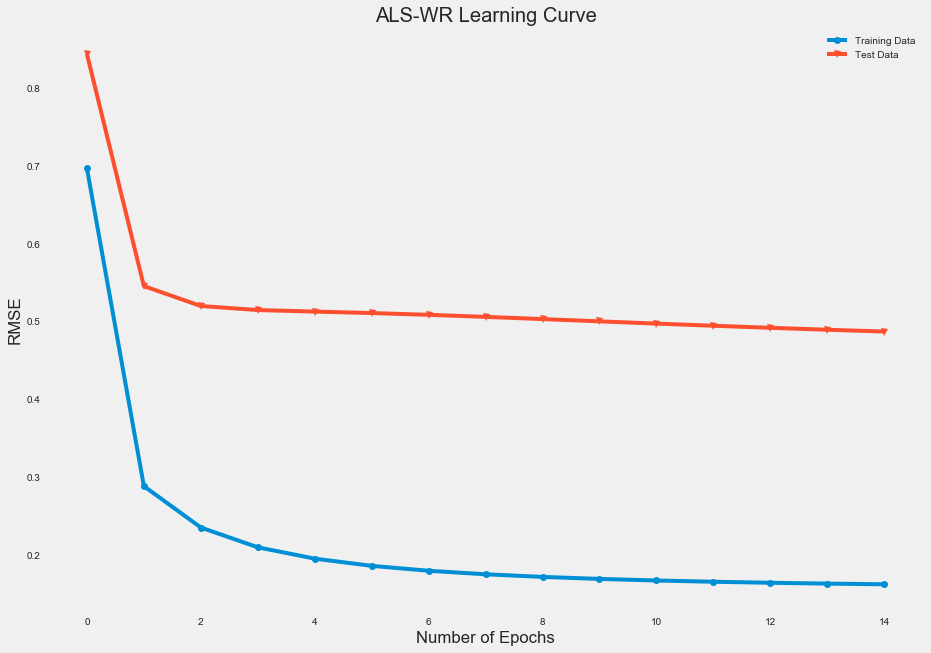

In [384]:
plt.plot(range(n_iterations), train_errors, marker='o', label='Training Data');
plt.plot(range(n_iterations), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

Since both Train and Test decrease and converge over time, instead of the test error increasing for instance, suggests that we're not overfitting

To improve the model even more I would implement a grid search to optimize parameters.  These were chosen at random.

Ok Cool, now that we have error analysis to support our model, let's recommend some songs

In [385]:
# Calculate R_pred prediction matrix (low-rank approximation for R)
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:25.910596. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [386]:
user = 5

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:26.231682. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [387]:
# Compare true ratings of user 200 with predictions
ratings = pd.DataFrame(data=R.loc[user-1,R.loc[user-1,:] > 0])
ratings['Prediction'] = R_hat.loc[user-1,R.loc[user-1,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:26.526905. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [388]:
ratings.head(n=10)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:26.835026. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Actual Rating,Predicted Rating
0,1.0,0.927573
1,1.0,1.043855
5,2.0,1.792501
7,1.0,1.001244
8,2.0,1.846120
15,1.0,1.055231
75,1.0,1.023240
99,2.0,1.785107


In [389]:
ratings['difference'] = abs(ratings['Actual Rating']- ratings['Predicted Rating'])

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:27.293819. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [390]:
ratings['difference'].mean()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:27.573500. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


0.096533514517459548

In [391]:
predictions = R_hat.loc[user-1,R.loc[user-1,:] == 0] 
predictions = predictions.sort_values(ascending=False)
recommendations = pd.DataFrame(data=predictions)
recommendations.columns = ['Predicted Rating']


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:27.877734. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [392]:
recommendations

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:28.169013. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Predicted Rating
12,1.241955
27,1.233115
38,1.207987
66,1.126271
52,1.106111
30,1.046929
29,1.042043
9,0.994284
84,0.917797
36,0.916238


In [393]:
print R_hat.shape
print R_hat.loc[user-1,R.loc[user-1,:] != 0].shape
print predictions.shape

(196, 100)
(8,)
(92,)


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:28.495376. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [394]:
not_seen = songs[songs['index'].isin((recommendations.index))]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:29.525969. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [395]:
not_seen.columns = ['item_id','song_played']

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:29.935355. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [396]:
recommendations = recommendations.reset_index()
recommendations.columns = ['item_id','Predicted Rating']

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:30.199601. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [397]:
recommendations = pd.merge(recommendations,not_seen, on='item_id')
recommendations = recommendations.set_index('item_id')

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:30.456734. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [398]:
# Songs Listened To
songs[songs['index'].isin(df2[df2['user_id'] == user]['item_id'])]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:30.726201. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,index,song_played
0,0,Hey Jude
1,1,We Can Work It Out
2,2,Back In the U.S.S.R.
6,6,Hello Goodbye
8,8,Revolution
9,9,Let It Be
13,16,Come Together
30,76,Birthday
38,100,I Saw Her Standing There
41,112,Eleanor Rigby


In [399]:
recommendations = recommendations[~recommendations.song_played.isin(list(songs[songs['index'].isin(df2[df2['user_id'] == user]['item_id'])]['song_played']))]

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:31.498122. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [400]:
# Song Recommendations for our user
recommendations

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-21 10:51:31.818385. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Predicted Rating,song_played
item_id,,
12,1.241955,The Fool On The Hill
30,1.046929,Here Comes The Sun
4,0.905031,Sgt. Pepper's Lonely Hearts Club Band
40,0.900373,Don't Let Me Down
32,0.821831,Getting Better
3,0.812637,P.s. I Love You
53,0.691155,"Ob-la-di, Ob-la-da"
31,0.630547,A Day In The Life
39,0.274590,Lucy In The Sky With Diamonds


###  How would you set up a test to check whether your model works well and is improving engagement?

* During the training phase we looked at the rmse, but in production it's much different

* So we need to perform a A/B test:
1. randomly split users into two groups, one Control group and one Experiment group
2. Control group has no recommendation strategy
3. Experiment group recommends the next song
4. after running some time, which we can determine by solving for sample size in the z-score formula, perform a one-tailed t-test on 'average play per day'

H0: population 'average play per day' is same in two groups

HA: experiment group's population 'averageplay per day' is higher than control group's